In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt

In [ ]:
# Hyperparameters
batch_size = 128
latent_size = 20
epochs = 50
learning_rate = 0.001

In [ ]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 208587754.59it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 30760714.53it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 66433799.51it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3484003.07it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

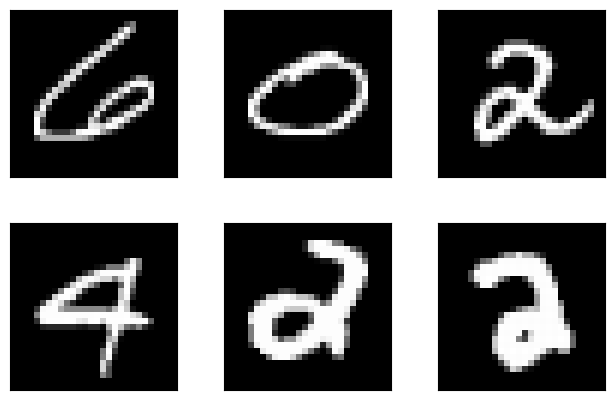

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])

In [ ]:
# VAE Model
class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()

    # Encoder layers
    self.encoder = nn.Sequential(
        nn.Linear(28*28, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, latent_size * 2)  # Two sets of outputs for mean and log(variance)
    )

    # Decoder layers
    self.decoder = nn.Sequential(
        nn.Linear(latent_size, 128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Linear(256, 28*28),
        nn.Sigmoid()  # Output between 0 and 1 for MNIST images
    )

  def reparameterize(self, mu, log_var):
      std = torch.exp(0.5*log_var)
      epsilon = torch.randn_like(std)
      return mu + epsilon * std

  def forward(self, x):
      # Encode
      h = self.encoder(x.view(-1, 28*28))
      mu, log_var = h[:, :latent_size], h[:, latent_size:]

      # Reparameterization trick
      z = self.reparameterize(mu, log_var)

      # Decode
      decoded = self.decoder(z)

      return decoded, mu, log_var

In [ ]:
# Loss function
def loss_function(recon_x, x, mu, log_var):
  BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')

  # KL divergence between the latent distribution and a standard normal distribution
  KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

  return BCE + KLD

In [ ]:
# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train(epoch):
  model.train()
  train_loss = 0
  for batch_idx, (data, _) in enumerate(train_loader):
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mu, log_var = model(data)
    loss = loss_function(recon_batch, data, mu, log_var)
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
  print('Epoch: {} Loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
  return train_loss / len(train_loader.dataset)

In [ ]:
# Train the model
loss_list = []
for epoch in range(1, epochs + 1):
  loss_list.append(train(epoch))

Epoch: 1 Loss: 188.2712
Epoch: 2 Loss: 138.1118
Epoch: 3 Loss: 124.8583
Epoch: 4 Loss: 118.4267
Epoch: 5 Loss: 114.8686
Epoch: 6 Loss: 112.5902
Epoch: 7 Loss: 111.0557
Epoch: 8 Loss: 109.8309
Epoch: 9 Loss: 108.7965
Epoch: 10 Loss: 107.9897
Epoch: 11 Loss: 107.3448
Epoch: 12 Loss: 106.7520
Epoch: 13 Loss: 106.2360
Epoch: 14 Loss: 105.8155
Epoch: 15 Loss: 105.3850
Epoch: 16 Loss: 105.0824
Epoch: 17 Loss: 104.7774
Epoch: 18 Loss: 104.4963
Epoch: 19 Loss: 104.2283
Epoch: 20 Loss: 103.9366
Epoch: 21 Loss: 103.7501
Epoch: 22 Loss: 103.5480
Epoch: 23 Loss: 103.3109
Epoch: 24 Loss: 103.1665
Epoch: 25 Loss: 102.9976
Epoch: 26 Loss: 102.8030
Epoch: 27 Loss: 102.7433
Epoch: 28 Loss: 102.5911
Epoch: 29 Loss: 102.4231
Epoch: 30 Loss: 102.3239
Epoch: 31 Loss: 102.2095
Epoch: 32 Loss: 102.1163
Epoch: 33 Loss: 101.9452
Epoch: 34 Loss: 101.8859
Epoch: 35 Loss: 101.7527
Epoch: 36 Loss: 101.6800
Epoch: 37 Loss: 101.5750
Epoch: 38 Loss: 101.5443
Epoch: 39 Loss: 101.3785
Epoch: 40 Loss: 101.3405
Epoch: 41

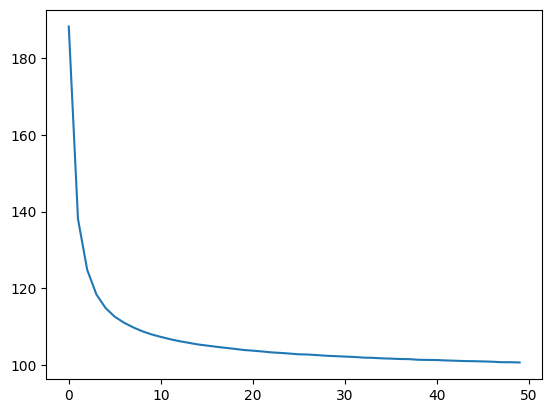

In [ ]:
plt.plot(loss_list)

In [ ]:
# Generating new samples
def generate_samples(num_samples):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_size).to(device)
        samples = model.decoder(z).cpu()
    return samples.view(-1, 1, 28, 28)

In [ ]:
samples = generate_samples(6)

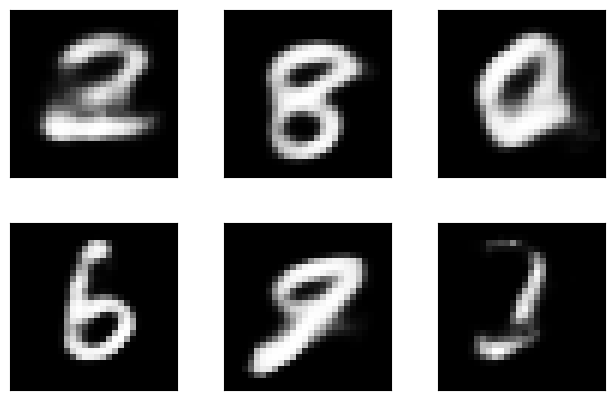

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(samples[i][0], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])